In [1]:
import timeit
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

from skimage.measure import label
import pyclesperanto_prototype as prototype
from pyclesperanto import Clesperanto

pyclic = Clesperanto()
pyclic.set_wait_for_kernel_to_finish()

prototype.select_device()
prototype.set_wait_for_kernel_finish()

In [2]:
def benchmark_prototype_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 20) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size) * 100
        image = image > 50
        
        gpu_image = prototype.push(image)
        gpu_result = prototype.create(image.shape)
        # bind target function to given image
        partial_function = partial(target_function, gpu_image, gpu_result)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=5)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

def benchmark_pyclic_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 20) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size) * 100
        image = image > 50
    
        gpu_image = pyclic.push(image)
        gpu_result = pyclic.create(image.shape)
        # bind target function to given image
        partial_function = partial(target_function, gpu_image, gpu_result)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=5)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

def benchmark_skimage_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 20) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size) * 100
        image = image > 50

        # bind target function to given image
        partial_function = partial(target_function, image)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=5)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)


# Labeling

In [3]:
def pyclic_function(gpu_image, gpu_result):
    pyclic.connected_components_labeling_box(input_image=gpu_image, output_image=gpu_result)

def prototype_function(gpu_image, gpu_result):
    prototype.connected_components_labeling_box(binary_input=gpu_image, labeling_destination=gpu_result)
    
def skimage_function(image):
    label(image)

In [4]:
time_pyclic_size = benchmark_pyclic_size(pyclic_function)
time_prototype_size = benchmark_prototype_size(prototype_function)
time_skimage_size = benchmark_skimage_size(skimage_function)

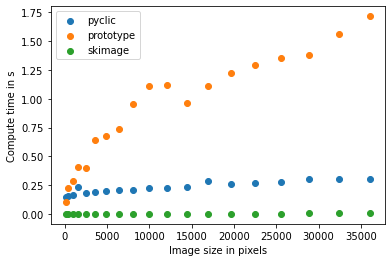

In [5]:
plt.scatter(time_pyclic_size[:,0] ** 2, time_pyclic_size[:,1])
plt.scatter(time_prototype_size[:,0] ** 2, time_prototype_size[:,1])
plt.scatter(time_skimage_size[:,0] ** 2, time_skimage_size[:,1])

plt.legend(["pyclic", "prototype", "skimage"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()